## Pset 4: Matching the US income distribution by GMM

In this problem set, you will use the tab-delimited data file usincmoms.txt, which contains the 42 moments listed in Table 1 along with the midpoint of each bin. The first column of the data file gives the percent of the population in each income bin (the third column of Table 1). The second column in the data file has the midpoint of each income bin. So the midpoint of the first income bin of all household incomes less than \$5,000 is \$2,500.

In [1]:
# Load Modules
import numpy as np
import scipy.stats as sts
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.special as spc
import scipy.integrate as integrate
import distributions as dst
import numpy.linalg as lin

In [2]:
usincmoms = pd.read_table("usincmoms.txt", header=None, names = ["PercPop","IncomeMidpoint"])

(a) Plot the histogram implied by the moments in the tab-delimited text file usincmoms.txt. The centers of each bin are in the second column of the data fie usincmoms.txt. List the dollar amounts on the x-axis as thousands of dollars. The bin cutoffs are given in Table 1. Even though the top bin is all incomes of \$250,000 and up, only graph the histogram up to the maximum income of \$350,000. In summary, your histogram should have 42 bars. The first 40 bars for the lowest income bins should be the same width. The last two bars should be different widths from each other and from the rest of the bars. Because the 41st bar is 10 times bigger than the first 40 bars, divide its height by 10. Because the 42nd bar is 20 times bigger than the first 40 bars, divide its height by 20. This is analogous to dividing the last two bars into 10 and 20 bars respectively, and spreading frequency of each evenly among its divisions.

<IPython.core.display.Javascript object>


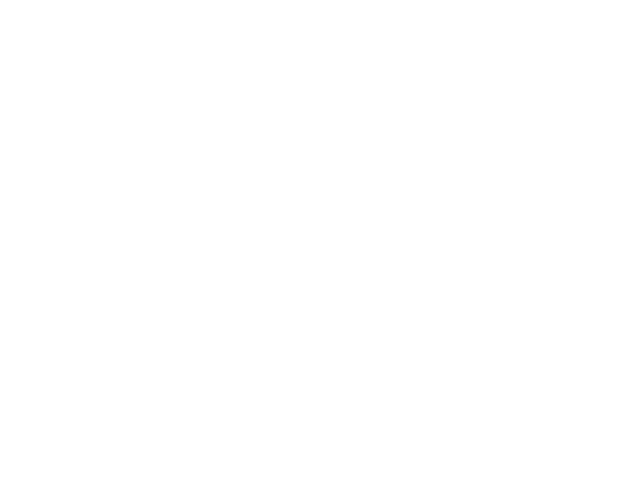

In [3]:
# Create first Histogram
# This command is specifically for Jupyter Notebook
%matplotlib notebook

# Construct sequence of bins
bins = list(((usincmoms["IncomeMidpoint"].shift() + usincmoms["IncomeMidpoint"])/2000))
bins[0] = 0
bins[40] = 200.0
bins[41] = 250.0
bins.append(350.0)

# Construct data values
datavals = usincmoms["IncomeMidpoint"]/1000

# Construct weights
moms_data = list(usincmoms["PercPop"])
moms_data[40] = moms_data[40]/10
moms_data[41] = moms_data[41]/20
moms_data = np.array(moms_data)

# Plot Histogram
count, bins, ignored = plt.hist(datavals, bins=bins, weights=moms_data)
plt.title('Distribution of Household Money Income by Income Class', fontsize=15)
plt.xlabel('US Dollars (Thousands)')
plt.ylabel('Percent of Households')

(b) Using GMM, fit the lognormal $LN(x;\mu,\sigma)$ distribution defined in the MLE notebook to the distribution of household income data using the moments from the data file. Make sure to try various initial guesses. (HINT: $\mu_0 = \ln(avg.inc)$ might be good.) For your weighting matrix $W$, use a $42 \times 42$ diagonal matrix in which the diagonal elements are the percentages from the data file. This will put the most weight on the moments with the largest percent of the population. Report your estimated values for $\hat{\mu}$ and $\hat{\sigma}$, as well as the value of the minimized criterion function $e(x|\hat{\theta})^T W e(x|\hat{\theta})$. Plot the histogram from part (a) overlayed with a line represeing the implied histogram from your estimated lognormal (LN) distribution. Each point on the line is the midpoint of the bin and the implied height of the bin. Do not forget to divide the values for your last two moments by 10 and 20 respectively, so that they match up with the histogram.

In [4]:
def model_moments(mu, sigma, bins):
    
    xfx = lambda x: dst.log_norm_pdf(x,mu,sigma)
        
    model_moments = []
    for i in range(1,np.prod(bins.shape)):
        model_moments.append(integrate.quad(xfx,bins[i-1],bins[i])[0])
        
    return model_moments

def err_vec(mu, sigma, bins, moms_data):
    moms_model = model_moments(mu, sigma, bins)
    return np.divide(np.subtract(np.array(moms_model),np.array(moms_data)), np.array(moms_data))

def criterion(params, *args):
    mu, sigma = params
    bins, moms_data, W = args
    err = err_vec(mu, sigma, bins, moms_data)
    return np.dot(np.dot(err.T, W), err) 

# Some checks

#model_moments(20,10,bins)
#err_vec(3.9,10,list(bins),moms_data)

In [5]:
# Run GMM Estimation
mu_init = 3.9
sig_init = 10
params_init = np.array([mu_init, sig_init])

bins_input = list(bins)
bins_input = np.array(bins_input)
bins_input[0] = 1e-8
W_hat = np.diag(usincmoms["PercPop"],0)
gmm_args = (bins_input, np.array(moms_data), W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
results

mu_GMM1= 41.3858279533  sig_GMM1= 23.0833320278


      fun: 0.89933416991386383
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.22044605e-06,  -4.09672296e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 57
      nit: 18
   status: 0
  success: True
        x: array([ 41.38582795,  23.08333203])

In [6]:
# Check that the criterion function matches when run manually
criterion(np.array([mu_GMM1, sig_GMM1]), bins_input, np.array(moms_data), W_hat)

0.89933416991386383

In [7]:
#print(moms_data)
#print(np.array(model_moments(mu_GMM1, sig_GMM1, bins)))
#print(err_vec(mu_GMM1, sig_GMM1,bins,moms_data))
#errGMM1 = err_vec(mu_GMM1, sig_GMM1,bins,moms_data)
#print(np.dot(np.dot(errGMM1.T, W_hat), errGMM1))
#model_moments(mu_GMM1,sig_GMM1,bins)

<IPython.core.display.Javascript object>


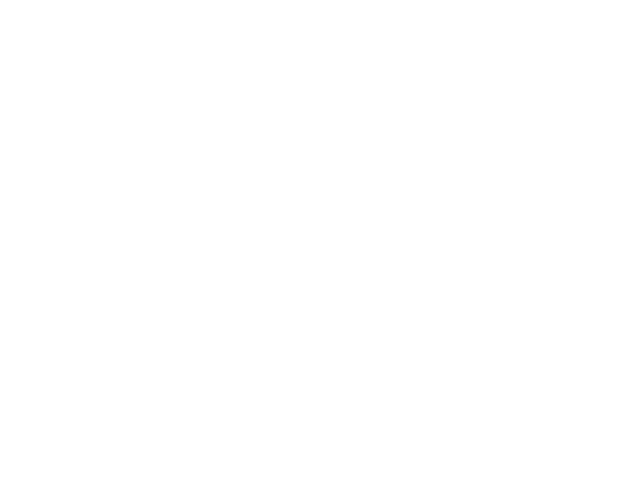

C:\Users\merub\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:356: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


In [8]:
%matplotlib notebook 
# Plot Histogram
plt.hist(datavals, bins=bins, weights=moms_data)

# Plot the MLE estimated distribution
dist_pts = np.linspace(0, 350, 350)
#plt.plot(dist_pts, dst.log_norm_pdf(dist_pts,mu_GMM1,sig_GMM1), linewidth=2, color='r', label='GMM Fit')
for_plot = model_moments(mu_GMM1,sig_GMM1,bins)
for_plot[40] = for_plot[40]/10
for_plot[41] = for_plot[41]/20

plt.plot(datavals, for_plot, linewidth=2, color='r', label='GMM Fit - Log Normal')

plt.title('Distribution of Household Money Income by Income Class', fontsize=15)
plt.xlabel('US Dollars (Thousands)')
plt.ylabel('Percent of Households')
plt.legend(loc='upper right')

(c) Using GMM, fit the gamma $GA(x;\alpha,\beta)$ distribution defined in the MLE notebook to the distribution of household income data using the moments from the data file. Use $\alpha_0 = 3$ and $\beta_0 = 20$ as your initial guess. Report your estimated values for $\hat{\alpha}$ and $\hat{\beta}$ as well ass the value of the minimized criterion function $e(x,\hat{\theta})$. Use the same weighting matrix as in part (b). Plot the histogram from part (a) overlayed with a line representing the implied histogram from your estimated gamma (GA) distribution. Do not forget to divide the values for your last two moments by 10 and 20, respectively, so that they match up with the histogram.

In [9]:
def model_moments2(alpha, beta, bins):
    
    xfx = lambda x: dst.gamma_pdf(x,alpha,beta)
        
    model_moments = []
    for i in range(1,np.prod(bins.shape)):
        model_moments.append(integrate.quad(xfx,bins[i-1],bins[i])[0])
        
    return model_moments

def err_vec2(alpha, beta, bins, moms_data):
    moms_model = model_moments2(alpha, beta, bins)
    return np.divide(np.subtract(np.array(moms_model),np.array(moms_data)), np.array(moms_data))

def criterion2(params, *args):
    alpha, beta = params
    bins, moms_data, W = args
    err = err_vec2(alpha, beta, bins, moms_data)
    return np.dot(np.dot(err.T, W), err) 

# Some checks

#model_moments(20,10,bins)
#err_vec(3.9,10,list(bins),moms_data)

In [10]:
# Run GMM Estimation
alpha_init = 3
beta_init = 20
params_init = np.array([alpha_init, beta_init])

gmm_args = (bins_input, np.array(moms_data), W_hat)

results2 = opt.minimize(criterion2, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
alpha_GMM2, beta_GMM2 = results2.x
print('alpha_GMM2=', alpha_GMM2, ' beta_GMM2=', beta_GMM2)
results2

alpha_GMM2= 1.83671753238  beta_GMM2= 27.8459405002


      fun: 0.085531567863429567
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  7.67441666e-07,   5.55111512e-09])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 36
      nit: 11
   status: 0
  success: True
        x: array([  1.83671753,  27.8459405 ])

In [11]:
# Check that the criterion function matches when run manually
criterion2(np.array([alpha_GMM2, beta_GMM2]), bins_input, np.array(moms_data), W_hat)

0.085531567863429567

<IPython.core.display.Javascript object>


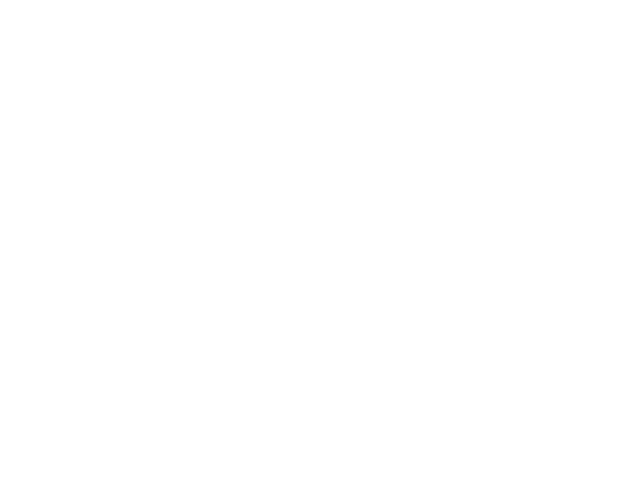

In [12]:
%matplotlib notebook 
# Plot Histogram
plt.hist(datavals, bins=bins, weights=moms_data)

# Plot the MLE estimated distribution
for_plot2 = model_moments2(alpha_GMM2,beta_GMM2,bins)
for_plot2[40] = for_plot2[40]/10
for_plot2[41] = for_plot2[41]/20

plt.plot(datavals, for_plot2, linewidth=2, color='r', label='GMM Fit - Gamma')

plt.title('Distribution of Household Money Income by Income Class', fontsize=15)
plt.xlabel('US Dollars (Thousands)')
plt.ylabel('Percent of Households')
plt.legend(loc='upper right')

Plot the histogram from part (a), the line from part (b) and the line from part (c)

<IPython.core.display.Javascript object>


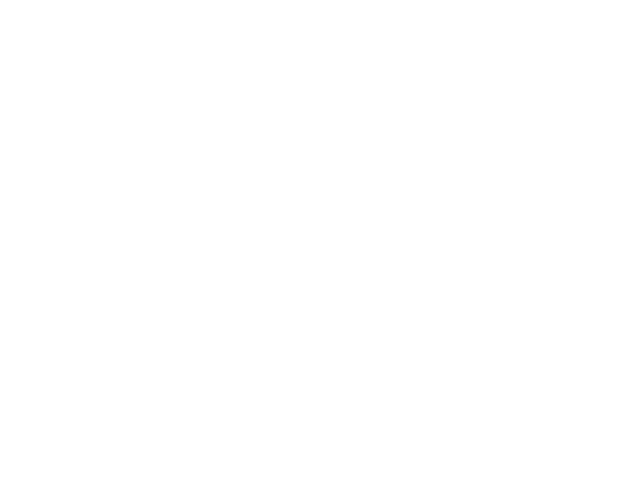

In [13]:
%matplotlib notebook 
# Plot Histogram
plt.hist(datavals, bins=bins, weights=moms_data)

# Plot the MLE estimated distribution
for_plot2 = model_moments2(alpha_GMM2,beta_GMM2,bins)
for_plot2[40] = for_plot2[40]/10
for_plot2[41] = for_plot2[41]/20

plt.plot(datavals, for_plot2, linewidth=2, color='r', label='GMM Fit - Gamma')
plt.plot(datavals, for_plot, linewidth=2, color='y', label='GMM Fit - Log Normal')

plt.title('Distribution of Household Money Income by Income Class', fontsize=15)
plt.xlabel('US Dollars (Thousands)')
plt.ylabel('Percent of Households')
plt.legend(loc='upper right')

Based on the above plot, the Gamma distribution fits the data the best. I played around with it a bit, and even a Normal distribution does a reasonable job, which suggests that a truncated normal could be an excellent fit. 

(e) Repeat your estimation of the GA distribution from part (c) but use the two-step estimator for the optimal weighting matrix. Do your estimates for $\alpha$ and $\beta$ change much? How can your compare the goodness of fit of this estimated distribution versus the goodness of fit of the estimated distribution in part (c)?

In [14]:
# Construct new weighting matrix:
err_GMM2 =  err_vec2(alpha_GMM2, beta_GMM2, bins, moms_data)
#N = np.prod(err_GMM2.shape)
N = np.sum(np.outer(err_GMM2,err_GMM2))
W_twostep = lin.pinv((1/N)*np.outer(err_GMM2,err_GMM2))
#print(W_twostep)

# Run GMM Estimation
params_init = np.array([alpha_GMM2, beta_GMM2])

gmm_args = (bins_input, np.array(moms_data), W_twostep)

results3 = opt.minimize(criterion2, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
alpha_GMM3, beta_GMM3 = results3.x
print(results3)
print('alpha_GMM2=', alpha_GMM2, ' beta_GMM2=', beta_GMM2)
print('alpha_GMM3=', alpha_GMM3, ' beta_GMM3=', beta_GMM3)

      fun: 7.941540481460176e-12
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -8.28813777e-06,  -1.01404989e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 33
      nit: 10
   status: 0
  success: True
        x: array([  3.93741775,  25.05496815])
alpha_GMM2= 1.83671753238  beta_GMM2= 27.8459405002
alpha_GMM3= 3.93741774565  beta_GMM3= 25.0549681472


In [15]:
# Check that the criterion function matches when run manually
criterion2(np.array([alpha_GMM3, beta_GMM3]), bins_input, np.array(moms_data), W_twostep)

7.941540481460176e-12

In [16]:
# Run iterated GMM
alpha_init = 3
beta_init = 20
W_hat = np.diag(moms_data,0)

check = []
check2 = 10 # Any Large Number
iter = 0
#for i in range(1,100):
while check2 > 1e-9:
    #print(alpha_init,beta_init)
    params_init = np.array([alpha_init, beta_init])
    gmm_args = (bins_input, np.array(moms_data), W_hat)
    #print(W_hat) 
    results3 = opt.minimize(criterion2, params_init, args=(gmm_args),
                           method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
    alpha_val, beta_val = results3.x

    err_val =  err_vec2(alpha_val, beta_val, bins, moms_data)
    #N = np.prod(err_GMM2.shape)
    N = np.sum(np.outer(err_val,err_val))
    W_hat_new = lin.pinv((1/N)*np.outer(err_val,err_val))
    check.append(np.sum(np.square(np.subtract(W_hat, W_hat_new))))
    iter += 1
    if iter > 1:
        check2 = (((check[iter-1] - check[iter-2])/check[iter-2])**2)**(1/2)
    #print(check[iter-1])
    #print(check2)
    W_hat = np.copy(W_hat_new)
    alpha_init = alpha_val
    beta_init=beta_val
 
#print(alpha_init,beta_init)
print(W_hat)
print(iter)
alpha_GMM_Iter = alpha_init
beta_GMM_Iter = beta_init
W_iter = np.copy(W_hat)
print('alpha_GMM2=', alpha_GMM2, ' beta_GMM2=', beta_GMM2)
print('alpha_GMM3=', alpha_GMM3, ' beta_GMM3=', beta_GMM3)
print('alpha_GMM_Iter=', alpha_GMM_Iter, ' beta_GMM_Iter=', beta_GMM_Iter)
results3

[[ 0.12026319  0.10990896  0.09616949 ...,  0.1007884   0.02666085
   0.10735113]
 [ 0.10990896  0.10044619  0.08788964 ...,  0.09211088  0.02436545
   0.09810858]
 [ 0.09616949  0.08788964  0.07690276 ...,  0.08059631  0.02131958
   0.08584425]
 ..., 
 [ 0.1007884   0.09211088  0.08059631 ...,  0.08446725  0.02234353
   0.08996725]
 [ 0.02666085  0.02436545  0.02131958 ...,  0.02234353  0.00591038
   0.02379841]
 [ 0.10735113  0.09810858  0.08584425 ...,  0.08996725  0.02379841
   0.09582538]]
165
alpha_GMM2= 1.83671753238  beta_GMM2= 27.8459405002
alpha_GMM3= 3.93741774565  beta_GMM3= 25.0549681472
alpha_GMM_Iter= 3.92611002931  beta_GMM_Iter= 16.2325430376


      fun: 8.4786495529290823e-16
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.72762915e-07,  -8.58069959e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 33
      nit: 10
   status: 0
  success: True
        x: array([  3.92611003,  16.23254304])

In [17]:
# Check that the criterion function matches when run manually
criterion2(np.array([alpha_GMM_Iter, beta_GMM_Iter]), bins_input, np.array(moms_data), W_iter) #?

26.554121033894702

<IPython.core.display.Javascript object>


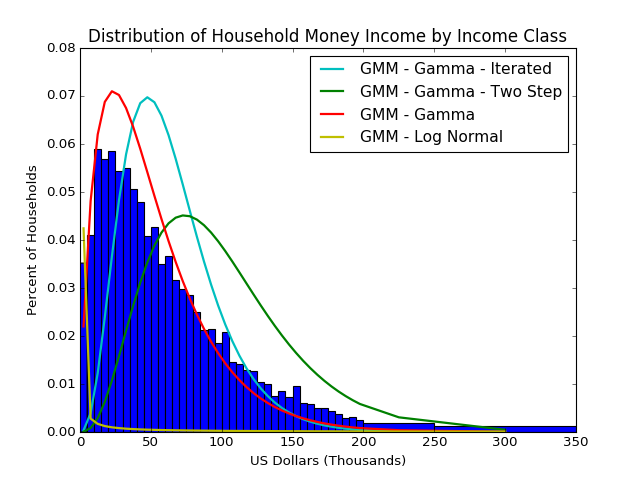

In [18]:
%matplotlib notebook 
# Plot Histogram
plt.hist(datavals, bins=bins, weights=moms_data)

# Plot the GMM estimated distribution
for_plot2 = model_moments2(alpha_GMM2,beta_GMM2,bins)
for_plot2[40] = for_plot2[40]/10
for_plot2[41] = for_plot2[41]/20

# Plot the GMM estimated distribution using Two Step
for_plot3 = model_moments2(alpha_GMM3,beta_GMM3,bins)
for_plot3[40] = for_plot3[40]/10
for_plot3[41] = for_plot3[41]/20

# Plot the GMM estimated distribution using Iterated
for_plot4 = model_moments2(alpha_GMM_Iter,beta_GMM_Iter,bins)
for_plot4[40] = for_plot4[40]/10
for_plot4[41] = for_plot4[41]/20

plt.plot(datavals, for_plot4, linewidth=2, color='c', label='GMM - Gamma - Iterated')
plt.plot(datavals, for_plot3, linewidth=2, color='g', label='GMM - Gamma - Two Step')
plt.plot(datavals, for_plot2, linewidth=2, color='r', label='GMM - Gamma')
plt.plot(datavals, for_plot, linewidth=2, color='y', label='GMM - Log Normal')

plt.title('Distribution of Household Money Income by Income Class', fontsize=15)
plt.xlabel('US Dollars (Thousands)')
plt.ylabel('Percent of Households')
plt.legend(loc='upper right', fontsize=14)
#plt.xlim([1e-8, 350])  # This gives the xmin and xmax to be plotted"
